<a href="https://colab.research.google.com/github/JasperAD11/Sentiment-Across-Signals-Neural-Networks-vs.-LLMs/blob/main/notebook_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

## Libraries and GloVe

In [1]:
import tensorflow as tf
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import TextVectorization, Input, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Binary model

### Dataset

In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5305k      0  0:00:15  0:00:15 --:--:-- 13.3M


In [3]:
# Directory path
dataset_dir = "aclImdb"

# Remove unsup data (not labeled)
shutil.rmtree(os.path.join(dataset_dir, 'train', 'unsup'))

# Load training and test sets
batch_size = 32
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)

val_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed
)

test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    batch_size=batch_size
)

# To train the Final Model
full_train_ds = train_ds.concatenate(val_ds).shuffle(10000)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [4]:
max_vocab = 20000
sequence_len = 300

vectorizer = TextVectorization(
    max_tokens=max_vocab,
    output_mode='int',
    output_sequence_length=sequence_len
)

# Adapt vectorizer on training data
text_only_train = train_ds.map(lambda x, y: x)
vectorizer.adapt(text_only_train)

In [5]:
# Convert datasets to NumPy arrays or tensors
def vectorize_dataset(ds):
    return ds.map(lambda x, y: (vectorizer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = vectorize_dataset(train_ds)
val_ds = vectorize_dataset(val_ds)
test_ds = vectorize_dataset(test_ds)
full_train_ds = vectorize_dataset(full_train_ds)


### Final Binary Model (model 2)

In [6]:
model_binary = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),  # Sequence → single vector    TEST WITHOUT

    # Dense layer 1
    layers.Dense(8, activation='relu'),

    # Dense layer 2
    layers.Dense(8, activation='relu'),

    # Dense layer 3 (Output)
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model_binary.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [7]:
history = model_binary.fit(
    full_train_ds,
    validation_data = test_ds,
    epochs=20,
    callbacks = [
        EarlyStopping(monitor='val_AUC', patience=10, restore_best_weights=True, mode='max'),
        ModelCheckpoint('best_model_binary.h5', monitor='val_accuracy', save_best_only=True, mode='max')]
)

model_binary.summary()

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6301 - loss: 0.6197

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_AUC` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6302 - loss: 0.6196 - val_accuracy: 0.8548 - val_loss: 0.3526
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8688 - loss: 0.3078

782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8688 - loss: 0.3078 - val_accuracy: 0.8742 - val_loss: 0.3075
Epoch 3/20
769/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9064 - loss: 0.2318

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9065 - loss: 0.2317 - val_accuracy: 0.8754 - val_loss: 0.3067
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9279 - loss: 0.1883 - val_accuracy: 0.8733 - val_loss: 0.3203
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9425 - loss: 0.1571 - val_accuracy: 0.8683 - val_loss: 0.3481
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9522 - loss: 0.1373 - val_accuracy: 0.8457 - val_loss: 0.4238
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9435 - loss: 0.1502 - val_accuracy: 0.7756 - val_loss: 0.6509
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9447 - loss: 0.1472 - val_accuracy: 0.8522 - val_loss: 0.4119
Epoch 9/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9538 - loss: 0.1279 - val_accuracy: 0.8324 - val_loss: 0.4691
Epoch 10/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9560 - loss: 0.1224 - val_accuracy: 0.8330 - val

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,683,341 (29.31 MB)

 Trainable params: 2,561,113 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,122,228 (19.54 MB)

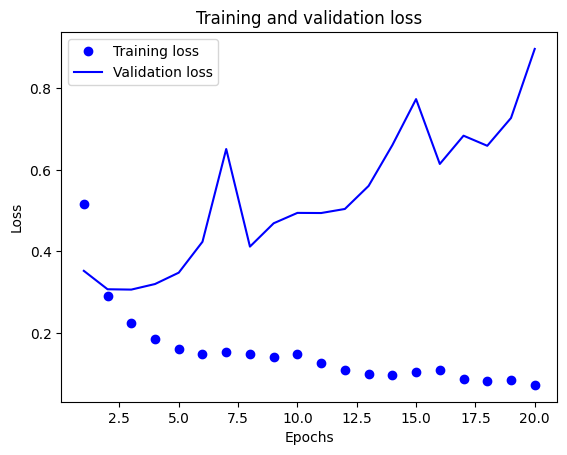

In [8]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

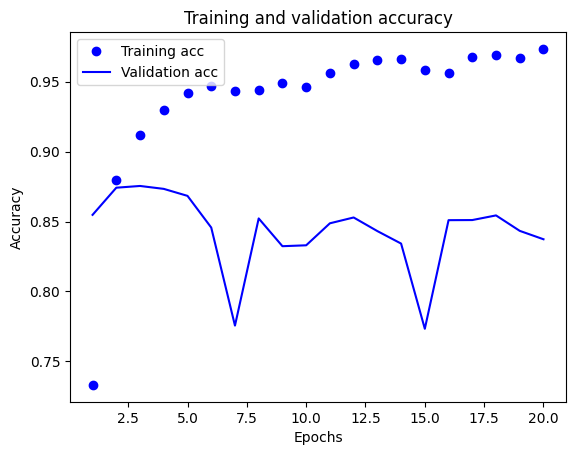

In [9]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [10]:
# def predict_binary(text):
#    text_tensor = tf.convert_to_tensor([text])
#    pred = model_binary.predict(text_tensor)[0][0]
#    return "positive" if pred >= 0.5 else "negative"

# print(predict_binary("The direction and cinematography were absolutely brilliant."))
# print(predict_binary("So bad I would watch it again."))
# print(predict_binary("Bad."))
# print(predict_binary("I did not like it."))

## Multi-class model

### Dataset

In [11]:
# Unzip to a folder
!unzip emotions-goemotions.zip -d emotions_data

Archive:  emotions-goemotions.zip
   creating: emotions_data/goemotions/
  inflating: emotions_data/goemotions/.DS_Store  
  inflating: emotions_data/__MACOSX/goemotions/._.DS_Store  
   creating: emotions_data/goemotions/data/
  inflating: emotions_data/__MACOSX/goemotions/._data  
  inflating: emotions_data/goemotions/data/.DS_Store  
  inflating: emotions_data/__MACOSX/goemotions/data/._.DS_Store  
   creating: emotions_data/goemotions/data/full_dataset/
  inflating: emotions_data/__MACOSX/goemotions/data/._full_dataset  
  inflating: emotions_data/goemotions/data/full_dataset/goemotions_1.csv  
  inflating: emotions_data/__MACOSX/goemotions/data/full_dataset/._goemotions_1.csv  
  inflating: emotions_data/goemotions/data/full_dataset/goemotions_3.csv  
  inflating: emotions_data/goemotions/data/full_dataset/goemotions_2.csv  


In [12]:
dataset = pd.read_csv('emotions_data/goemotions/data/full_dataset/goemotions_1.csv')

In [13]:
dataset.drop(columns=["id","author","subreddit","link_id","parent_id","created_utc","rater_id","example_very_unclear"], inplace=True)

In [14]:
# vectorizer.adapt(dataset['text'].values)

X = vectorizer(dataset['text'].values)

y = dataset.drop(columns=['text'])

In [15]:
X_numpy = X.numpy() if isinstance(X, tf.Tensor) else X
X_train_full, X_test, y_train_full, y_test = train_test_split(X_numpy, y, test_size=0.2, random_state=42)

# Second split: Take 20% of training for validation (16% of original)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42
)

### Final Multi-class Model (model 5)

In [26]:
model_multi_class = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(28, activation='sigmoid')
])

model_multi_class.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['AUC'])

In [27]:
history = model_multi_class.fit(X_train_full,
                                y_train_full,
                                epochs=50,
                                batch_size=32,
                                #validation_data=(X_val, y_val),
                                validation_data=(X_test, y_test),
                                callbacks = [
                                    EarlyStopping(monitor='val_AUC', patience=10, restore_best_weights=True),
                                    ModelCheckpoint('best_model_multi.h5', monitor='val_AUC', save_best_only=True, mode='max')]
)
model_multi_class.summary()

Epoch 1/50
1744/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6707 - loss: 0.1870

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - AUC: 0.6708 - loss: 0.1869 - val_AUC: 0.7329 - val_loss: 0.1575
Epoch 2/50
1742/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7139 - loss: 0.1595

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7139 - loss: 0.1595 - val_AUC: 0.7349 - val_loss: 0.1580
Epoch 3/50
1746/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7230 - loss: 0.1581

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7230 - loss: 0.1581 - val_AUC: 0.7387 - val_loss: 0.1569
Epoch 4/50
1741/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7305 - loss: 0.1565

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.7305 - loss: 0.1565 - val_AUC: 0.7420 - val_loss: 0.1568
Epoch 5/50
1736/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7370 - loss: 0.1556

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7371 - loss: 0.1555 - val_AUC: 0.7674 - val_loss: 0.1516
Epoch 6/50
1741/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7565 - loss: 0.1522

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7565 - loss: 0.1522 - val_AUC: 0.7788 - val_loss: 0.1494
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.7684 - loss: 0.1500 - val_AUC: 0.7757 - val_loss: 0.1494
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7783 - loss: 0.1481

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.7783 - loss: 0.1481 - val_AUC: 0.7943 - val_loss: 0.1461
Epoch 9/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7791 - loss: 0.1483 - val_AUC: 0.7845 - val_loss: 0.1481
Epoch 10/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.7887 - loss: 0.1464 - val_AUC: 0.7845 - val_loss: 0.1477
Epoch 11/50
1740/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7933 - loss: 0.1456

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7933 - loss: 0.1456 - val_AUC: 0.8066 - val_loss: 0.1431
Epoch 12/50
1748/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7971 - loss: 0.1445

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7971 - loss: 0.1445 - val_AUC: 0.8119 - val_loss: 0.1423
Epoch 13/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7988 - loss: 0.1440 - val_AUC: 0.8080 - val_loss: 0.1431
Epoch 14/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8043 - loss: 0.1430 - val_AUC: 0.8040 - val_loss: 0.1439
Epoch 15/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8088 - loss: 0.1416 - val_AUC: 0.8029 - val_loss: 0.1445
Epoch 16/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8131 - loss: 0.1410 - val_AUC: 0.7823 - val_loss: 0.1484
Epoch 17/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8142 - loss: 0.1408 - val_AUC: 0.8089 - val_loss: 0.1426
Epoch 18/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8145 - loss: 0.1406 - val_AUC: 0.8064 - val_loss: 0.1430
Epoch 19/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8169 - loss: 0.1400

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC: 0.8169 - loss: 0.1400 - val_AUC: 0.8219 - val_loss: 0.1402
Epoch 20/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8208 - loss: 0.1393 - val_AUC: 0.8215 - val_loss: 0.1409
Epoch 21/50
1739/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8237 - loss: 0.1382

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8237 - loss: 0.1382 - val_AUC: 0.8228 - val_loss: 0.1404
Epoch 22/50
1746/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8261 - loss: 0.1377

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8261 - loss: 0.1377 - val_AUC: 0.8263 - val_loss: 0.1387
Epoch 23/50
1734/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8290 - loss: 0.1373

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8290 - loss: 0.1373 - val_AUC: 0.8264 - val_loss: 0.1388
Epoch 24/50
1747/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8318 - loss: 0.1365

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8318 - loss: 0.1365 - val_AUC: 0.8296 - val_loss: 0.1373
Epoch 25/50
1745/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8331 - loss: 0.1360

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8331 - loss: 0.1360 - val_AUC: 0.8299 - val_loss: 0.1374
Epoch 26/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8389 - loss: 0.1346 - val_AUC: 0.8277 - val_loss: 0.1384
Epoch 27/50
1745/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8347 - loss: 0.1353

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8347 - loss: 0.1353 - val_AUC: 0.8382 - val_loss: 0.1357
Epoch 28/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8385 - loss: 0.1345 - val_AUC: 0.8244 - val_loss: 0.1400
Epoch 29/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8400 - loss: 0.1344 - val_AUC: 0.8289 - val_loss: 0.1372
Epoch 30/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8428 - loss: 0.1333 - val_AUC: 0.8352 - val_loss: 0.1367
Epoch 31/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8442 - loss: 0.1328 - val_AUC: 0.8282 - val_loss: 0.1376
Epoch 32/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8437 - loss: 0.1332 - val_AUC: 0.8327 - val_loss: 0.1375
Epoch 33/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8460 - loss: 0.1327 - val_AUC: 0.8284 - val_loss: 0.1415
Epoch 34/50
1741/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8472 - loss: 0.1322

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8472 - loss: 0.1322 - val_AUC: 0.8390 - val_loss: 0.1353
Epoch 35/50
1739/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8457 - loss: 0.1327

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8457 - loss: 0.1327 - val_AUC: 0.8419 - val_loss: 0.1345
Epoch 36/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8483 - loss: 0.1321

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8483 - loss: 0.1321 - val_AUC: 0.8426 - val_loss: 0.1346
Epoch 37/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8496 - loss: 0.1316 - val_AUC: 0.8365 - val_loss: 0.1388
Epoch 38/50
1734/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8512 - loss: 0.1312

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8512 - loss: 0.1312 - val_AUC: 0.8463 - val_loss: 0.1332
Epoch 39/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8523 - loss: 0.1311 - val_AUC: 0.8414 - val_loss: 0.1347
Epoch 40/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8550 - loss: 0.1299 - val_AUC: 0.8432 - val_loss: 0.1348
Epoch 41/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC: 0.8553 - loss: 0.1301 - val_AUC: 0.8406 - val_loss: 0.1348
Epoch 42/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8577 - loss: 0.1294 - val_AUC: 0.8452 - val_loss: 0.1355
Epoch 43/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8605 - loss: 0.1288 - val_AUC: 0.8311 - val_loss: 0.1405
Epoch 44/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8607 - loss: 0.1282 - val_AUC: 0.8379 - val_loss: 0.1358
Epoch 45/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8604 - loss: 0.1284 - val_AUC: 0.8385 - val_loss: 0.1362
Epoch 46/50
1749/1750 ━━━━━━━━━━━━━━━━━━

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8630 - loss: 0.1280 - val_AUC: 0.8491 - val_loss: 0.1323
Epoch 47/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8644 - loss: 0.1272 - val_AUC: 0.8461 - val_loss: 0.1337
Epoch 48/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8621 - loss: 0.1279

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8621 - loss: 0.1279 - val_AUC: 0.8515 - val_loss: 0.1317
Epoch 49/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC: 0.8669 - loss: 0.1268 - val_AUC: 0.8485 - val_loss: 0.1327
Epoch 50/50
1739/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8657 - loss: 0.1267

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8657 - loss: 0.1267 - val_AUC: 0.8553 - val_loss: 0.1305


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (32, 300, 128)         │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (32, 128)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 28)               │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,759,766 (29.60 MB)

 Trainable params: 2,586,588 (9.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,173,178 (19.73 MB)

## Merging **Binary** and **Multi class** models

In [28]:
def create_ensemble_model(sentiment_model_path, emotion_model_path):
    # Load the models
    sentiment_model = load_model(sentiment_model_path)
    emotion_model = load_model(emotion_model_path)

    # Freeze the models to prevent training
    sentiment_model.trainable = False
    emotion_model.trainable = False

    # Define new input layers
    sentiment_input = Input(shape=sentiment_model.input_shape[1:], name="sentiment_input")
    emotion_input = Input(shape=emotion_model.input_shape[1:], name="emotion_input")

    # Pass the inputs through the respective models
    sentiment_output = sentiment_model(sentiment_input)
    emotion_output = emotion_model(emotion_input)

    # Create the joint model
    joint_model = Model(
        inputs=[sentiment_input, emotion_input],
        outputs=[sentiment_output, emotion_output]
    )

    return joint_model

In [29]:
joint_model=create_ensemble_model('best_model_binary.h5', 'best_model_multi.h5')

In [30]:
joint_model.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sentiment_input     │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_input       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 1)         │  2,561,113 │ sentiment_input[… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 28)        │  2,586,588 │ emotion_input[0]… │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,147,701 (19.64 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,147,701 (19.64 MB)

In [31]:
# Define emotion labels (adjust to your actual labels)
emotion_labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
                  'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
                  'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
                  'remorse', 'sadness', 'surprise', 'neutral']

def predict_ensemble_model(model, texts, vectorizer, emotion_labels=emotion_labels, max_length=300, neutral_threshold=0.3, emotion_threshold=0.15):
    # Tokenize and pad the input texts
    input = vectorizer(texts)

    # Make predictions with the joint model
    predictions = model.predict({
        'sentiment_input': input,
        'emotion_input': input
    })

    # Get the sentiment prediction
    sentiment_prediction = predictions[0]

    # Convert sentiment prediction to 'positive' or 'negative' based on threshold of 0.5
    sentiment_label = "positive" if sentiment_prediction[0] > 0.5 else "negative"

    # Get emotion predictions
    emotion_predictions = predictions[1]

    # Map the emotion predictions to the emotion labels
    emotion_results = {emotion_labels[i]: emotion_predictions[0][i] for i in range(len(emotion_labels))}

    # Check if 'neutral' emotion has score > neutral_threshold
    if emotion_results.get('neutral', 0) >= neutral_threshold:
        # If neutral is above the threshold, only return "neutral"
        return {
            'sentiment': sentiment_label,
            'emotion': ['neutral']
        }

    # Filter emotions: return all emotions > emotion_threshold, excluding 'neutral'
    filtered_emotions = {emotion: score for emotion, score in emotion_results.items() if score > emotion_threshold and emotion != 'neutral'}

    # If no emotions are above the threshold, return only the emotion with the highest score, excluding 'neutral'
    if not filtered_emotions:
        max_emotion = max((emotion_results[key], key) for key in emotion_results if key != 'neutral')
        filtered_emotions = {max_emotion[1]: max_emotion[0]}

    # Return the predictions
    return {
        'sentiment': sentiment_label,  # Sentiment prediction as 'positive' or 'negative'
        'emotion': list(filtered_emotions.keys())  # List of emotions above threshold or best emotion
    }


In [32]:
predict_ensemble_model(joint_model, ["I am so excited!"], vectorizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


{'sentiment': 'negative', 'emotion': ['admiration', 'joy']}

In [33]:
!pip install openai-whisper

  Using cached openai-whisper-20240930.tar.gz (800 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu1

In [ ]:
!unzip Audios.zip -d audios_data

Archive:  Audios.zip
replace audios_data/audios/audio1.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import whisper
import pandas as pd

# Load Whisper model
model = whisper.load_model("base")

# Folder where your .mp4 files are located
folder = "/content/audios_data/audios"

# Transcribe each file
transcripts = []
for filename in os.listdir(folder):
    if filename.endswith(".mp4"):
        path = os.path.join(folder, filename)
        print(f"Transcribing: {filename}")
        result = model.transcribe(path, fp16=False)
        transcripts.append({
            "filename": filename,
            "whisper_transcription": result["text"]
        })

# Create DataFrame
df_transcripts = pd.DataFrame(transcripts)

# Optional: Show or save
print(df_transcripts)
df_transcripts.to_csv("/content/transcriptions.csv", index=False)
